# Group Project: Determining Diamond Cut Grades Using KNN Classification

**Section 009 Group 2**

**Ziqing Wang**<br>**Anna Tao**<br>**Ruby de Lang**

### 1. Introduction

The 4Cs: cut, clarity, color, and carat weight, are internationally accepted standards for assessing the quality of a diamond.  Diamond cut grade is a pivotal factor in determining the beauty and value of a diamond. Diamonds with an excellent cut exhibit exceptional brilliance, while very good cuts offer slightly lower cost without sacrificing visual appeal. Good cuts have an aesthetic appearance, though they may have reduced sparkle. In contrast, fair and poor cuts exhibit noticeable imperfections, appearing dull and less valuable.

The data set being examined in this project is a tabular data set that reports on the characteristics of diamonds (carat, color, clarity, price …). 
We want to explore the relationships between the quantitative data pieces, and use the KNN classification method to examine whether or not it can predict the cut grade of the diamond.

The columns of the dataset:
* **carat**: a unit of measurement for a diamond's weight, with one carat equal to 200 milligrams.
* **cut**: cut grades of diamonds, measured in five grades (high to low) in this dataset: Ideal, Premium, Very good, Good, Fair.
* **color**: color is graded on a scale from D (colorless) to Z (light yellow or brown), indicating the absence or presence of color in the stone.
* **clarity**: the presence of internal and external flaws or inclusions within a diamond, graded from Flawless (no inclusions) to Included (visible inclusions).
* **depth**: measures the distance from the table to the culet (the bottom of the diamond), influencing the diamond's visual size and light performance.
* **table**: the flat, topmost facet that affects the diamond's overall appearance and brilliance.
* **price**: The price of the diamond, can be determined by various factors.
* **x**: the x-dimension of diamonds.
* **y**: the y-dimension of diamonds.
* **z**: the z-dimension of diamonds.

### 2. Preliminary exploratory data analysis

In [1]:
#install.packages("GGally")
#install.packages("tidyverse")
#install.packages("cowplot")
library(tidyverse)
library(ggplot2)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

**Reading Data from Online Source Into R**

Before any data analysis/exploration, we must first download the diamond data from the website and read it as a CSV file in Jupyter.
After reading the data, we have 53940 recorded observations.

In [2]:
diamond_data <- read_csv("https://raw.githubusercontent.com/rubydelang/sonar_data/main/diamonds.csv") |>
mutate(cut = as_factor(cut))

#head(diamond_data)
diamond_data

diamond_split <- initial_split(diamond_data, prop = 0.75, strata = cut)
diamond_training <- training(diamond_split)
diamond_testing <- testing(diamond_split)

Rows: 53940 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): cut, color, clarity
dbl (7): carat, depth, table, price, x, y, z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


carat,cut,color,clarity,depth,table,price,x,y,z
<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48
0.24,Very Good,I,VVS1,62.3,57,336,3.95,3.98,2.47
0.26,Very Good,H,SI1,61.9,55,337,4.07,4.11,2.53
0.22,Fair,E,VS2,65.1,61,337,3.87,3.78,2.49


**Checking for Missing Data** 

We want to check for any NA values to make sure the data is consistent through the columns. Since we found no NA values, we still have 53940 observations to work with. 

The 'na_rows' counts for the number of rows containing missing data, and the result of 0 meaning we do not have any missing data in this dataset. Additionally, the dbl factors are correctly showing the minimum and maximum values, so we know they do not contain any missing information, otherwise they will output NA.<br><br>

In [3]:
na_rows <- sum(apply(is.na(diamond_data), 1, any))
na_rows
summary(diamond_data)

[1] 0

     carat               cut           color             clarity         
 Min.   :0.2000   Ideal    :21551   Length:53940       Length:53940      
 1st Qu.:0.4000   Premium  :13791   Class :character   Class :character  
 Median :0.7000   Good     : 4906   Mode  :character   Mode  :character  
 Mean   :0.7979   Very Good:12082                                        
 3rd Qu.:1.0400   Fair     : 1610                                        
 Max.   :5.0100                                                          
     depth           table           price             x         
 Min.   :43.00   Min.   :43.00   Min.   :  326   Min.   : 0.000  
 1st Qu.:61.00   1st Qu.:56.00   1st Qu.:  950   1st Qu.: 4.710  
 Median :61.80   Median :57.00   Median : 2401   Median : 5.700  
 Mean   :61.75   Mean   :57.46   Mean   : 3933   Mean   : 5.731  
 3rd Qu.:62.50   3rd Qu.:59.00   3rd Qu.: 5324   3rd Qu.: 6.540  
 Max.   :79.00   Max.   :95.00   Max.   :18823   Max.   :10.740  
       y            

**Mutating Data**

We want to predict the cut grades in this project. Our target variable is column cut, so we mutate the cut column to be type of fct instead of chr.

In [4]:
mutate_data <- diamond_data |>
    mutate(cut = as_factor(cut))

head(mutate_data) 


carat,cut,color,clarity,depth,table,price,x,y,z
<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48


**Tidy Data**

Now looking at the graph, each row is a single observation, each column is a single variable, and the column names are meaningful, and each cell contains only a single value. 
Therefore, the data is already tidy so we do not need take any further actions. <br><br>

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 6)

color_graph <- diamond_training |>
mutate(color = as_factor(color)) |>
group_by(color,cut) |>
summarize(count = n()) |>
ggplot(aes(color, y=count,fill=cut)) +
geom_bar(stat="identity", position="dodge") +
facet_grid(rows = vars(cut))

clarity_graph <- diamond_training |>
mutate(color = as_factor(color)) |>
group_by(clarity,cut) |>
summarize(count = n()) |>
ggplot(aes(x=clarity, y=count,fill=cut)) +
geom_bar(stat="identity", position="dodge") +
facet_grid(rows = vars(cut))

plot_grid(color_graph, clarity_graph, align = "h", ncol = 2)

I'm still trying to interpret these two results above.<br><br>

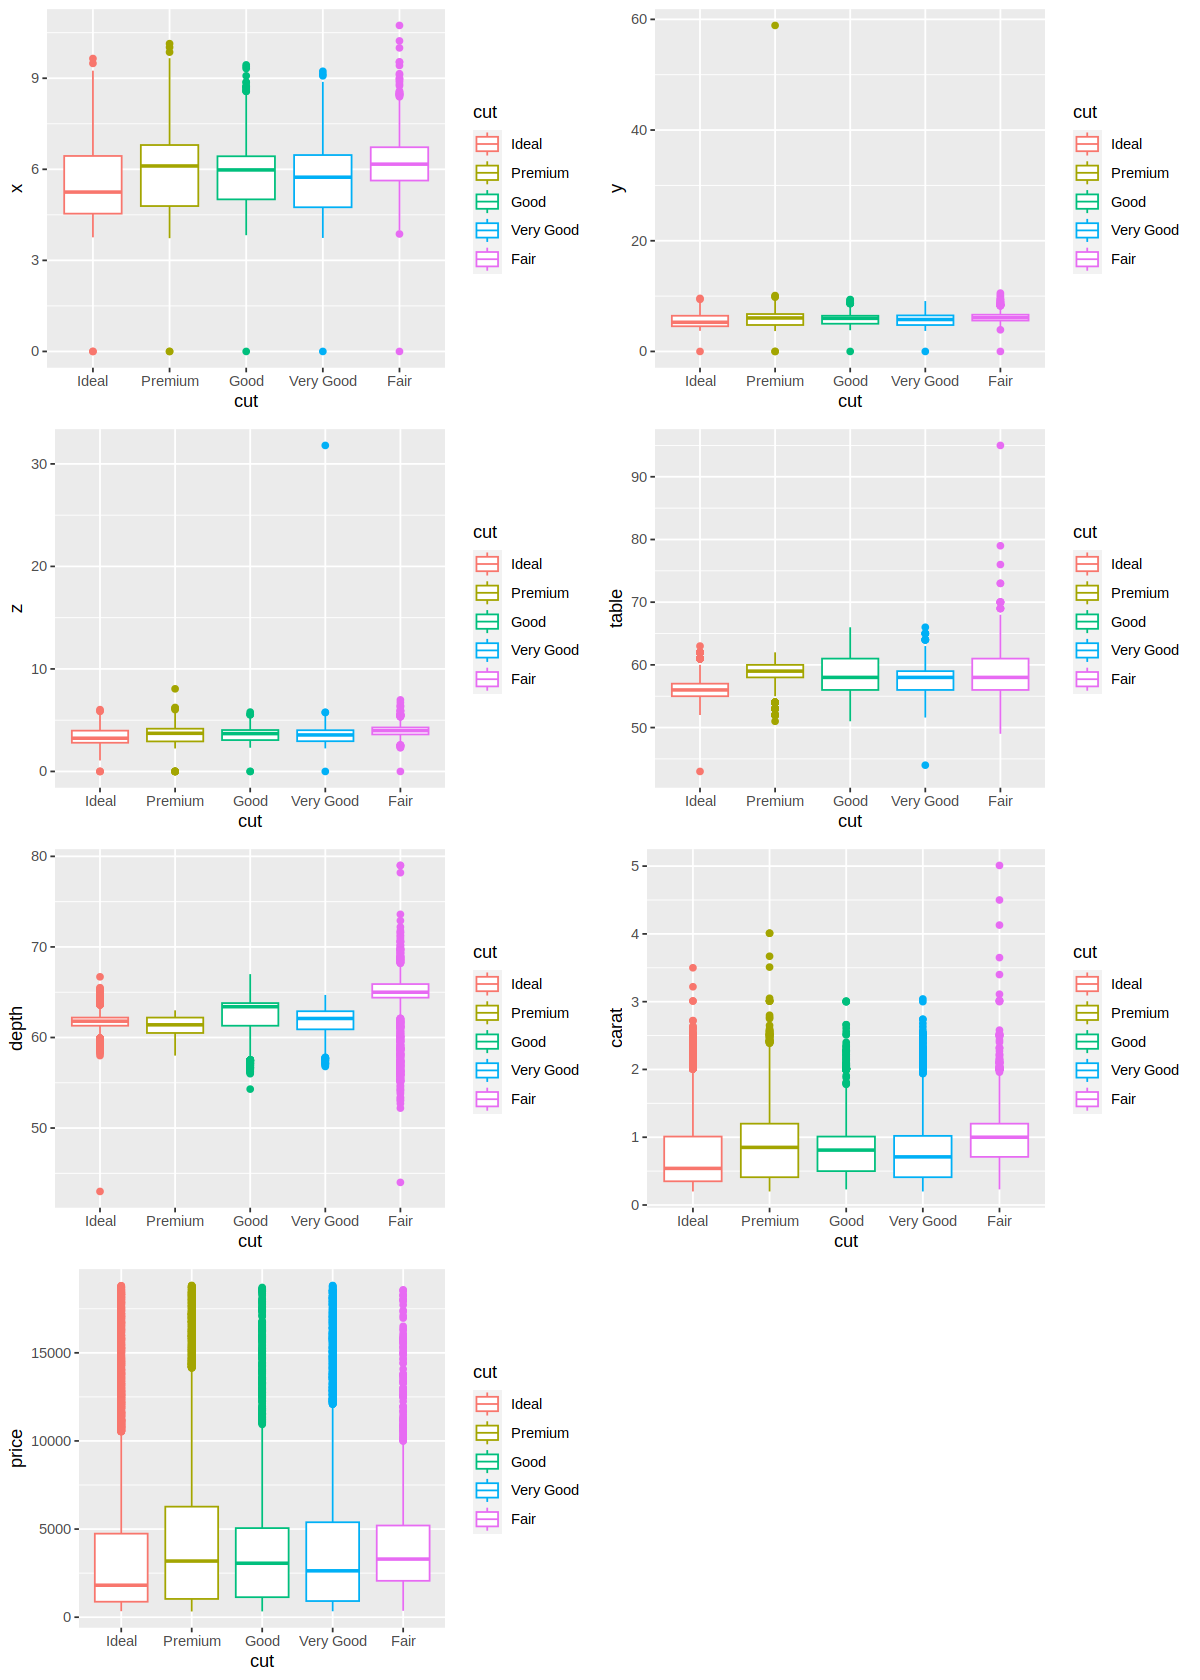

In [11]:
options(repr.plot.width = 10, repr.plot.height = 14)
x_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = x, color = cut)) +
geom_boxplot()

y_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = y, color = cut)) +
geom_boxplot()

z_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = z, color = cut)) +
geom_boxplot()

table_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = table, color = cut)) +
geom_boxplot()

depth_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = depth, color = cut)) +
geom_boxplot()

carat_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = carat, color = cut)) +
geom_boxplot()

price_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = price, color = cut)) +
geom_boxplot()

plot_grid(x_cut_graph, y_cut_graph, z_cut_graph, table_cut_graph, depth_cut_graph, carat_cut_graph, price_cut_graph, align = "h", ncol = 2)

The more separate the boxes are, the more accurate prediction it will make. Based on what we have from the graph, we can tell none of them are strongly associated with cut type. We can maximize the prediction accuracy by choosing the relatively associated factors like: depth and table.

### 3. Methods

**I will probably change this tmrw, cuz the graphs are messing up my mind, or guys just try to find better graphs to plot...** In reality, the cut grades are classified by experts based on how well the diamond can reflect light, or how “sparkling” the diamonds are under the light. The predictors like: x, y, z, depth, and table are all related to the symmetry of the diamond. However, based on the graphs we have plotted, the associations of the mentioned predictors with the cut grade are not so strong. Therefore, we choose to only use depth and table as predictors, if the accuracy is not desirable, we will add the x, y, and z in, too see if it will make the prediction result better. We hypothesize the addition of x, y, and z columns will not affect the accuracy too much because the boxes of each type are pretty much identical to each other.

### 4 Expected outcomes and significance

Based on the box plots, the expected outcome is that the predictive abilities of this data set will be low, as the plots all show that the associations between cut and the different tested variables (price, carat, depth, x, y, z, and table) are low. In terms of impacts, if the accuracy is desirable, the results of the classification accuracy can aide in streamlining the process of grading the cut of a diamond, if the important, and not important factors that impact the grade of the cut are known. \

**What future questions could this lead to?** 
1. What factors do affect the cut of the diamond?
2. How can the quality of the diamond cut me maximized? 

### References